In [1]:
%load_ext autoreload
%autoreload 2
import logging
import torch
from imp import reload
import matplotlib.pyplot as plt
import yaml
import numpy as np
import cv2
import os
from tqdm import tqdm
from load import *
#from celluloid import Camera
tqdm.get_lock().locks = []
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
plt.style.use('dark_background')

In [29]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world
from liftpose.main import test as lp3d_test
import scipy.io
from load import world_to_camera2

# decleare data parameters
par_train = {'data_dir' : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
           'out_dir'        : '/home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln/',
           'train_session_id' : [0],
           'test_session_id'  : [0],
           'test_cam_id'      : [3]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

#meta = mat73.loadmat('nolj_Recording_day8_caff1_nolj_imputed.mat')
# naming scheme used in the capture dataset for different cameras
cam_list = ['R', 'L', 'E', 'U', 'S', 'U2']

In [44]:
train_session_id = par_train["train_session_id"]
test_session_id = par_train["test_session_id"]
test_cam_id = par_train["test_cam_id"]

#mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
train_2d, train_3d, test_2d, test_3d = list(), list(), list(), list()
train_ind, test_ind = np.zeros((54000), dtype=bool), np.zeros((54000), dtype=bool)
train_ind[2000:] = True
test_ind[:2000] = True

train_keypoints = list()
test_keypoints = list()
session_id_list = np.unique(par_train["train_session_id"] + par_train["test_session_id"])
for session_id in session_id_list:
    mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
    for cam_id in range(len(cam_list)):
        mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
        c =  read_cam(session_id, cam_id)
        pts3d = mat[cam_id]['data_3d'].reshape(-1, 20, 3)
        pts3d = pts3d.reshape(-1, 3)
        
        pts2d = mat[cam_id]['data_2d'].reshape(-1, 20, 2)
        pts2d, _ = cv2.projectPoints(pts3d, rvec=c['r'].T, tvec=c['t'], cameraMatrix=c['K'].T, distCoeffs=None)
        pts2d = pts2d.reshape(-1, 20, 2)
        if session_id in train_session_id:
            train_2d.append(pts2d[train_ind])
        if session_id in test_session_id and cam_id in test_cam_id:
            test_2d.append(pts2d[test_ind])

        pts3d = world_to_camera2(pts3d, c['r'].T, c['t'])
        pts3d = pts3d.reshape(-1, 20, 3) 
        if session_id in train_session_id:
            train_3d.append(pts3d[train_ind])
        if session_id in test_session_id and cam_id in test_cam_id:
            test_3d.append(pts3d[test_ind])

train_2d = np.concatenate(train_2d, axis=0)
train_3d = np.concatenate(train_3d, axis=0)
test_2d = np.concatenate(test_2d, axis=0)
test_3d = np.concatenate(test_3d, axis=0)
train_keypoints = np.logical_not(np.isnan(train_3d))
test_keypoints = np.logical_not(np.isnan(test_3d))

# if more than one third is missing remove it
train_keypoints[np.sum(np.logical_not(train_keypoints), axis=(1,2)) > 20] = False
test_keypoints[np.sum(np.logical_not(test_keypoints), axis=(1,2)) > 20] = False

# if the root is none, then ignore that point, otherwise we cannot anchor
train_keypoints[np.any(np.isnan(train_2d[:,3]),axis=-1)] = False
test_keypoints[np.any(np.isnan(test_2d[:,3]),axis=-1)] = False

# impute nan's with zeros. zero 3d points will not be counted towards loss.
train_2d[np.isnan(train_2d)] = 0
#drop_ind = np.random.rand(train_2d.shape[0], train_2d.shape[1]) > 0.96
#train_2d[drop_ind] = 0
train_3d[np.isnan(train_3d)] = 0
test_2d[np.isnan(test_2d)] = 0
test_3d[np.isnan(test_3d)] = 0

In [3]:
lp3d_test(par['out_dir'])
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
test_3d_gt[np.logical_not(good_keypts.reshape(-1, 20, 3))] = np.nan

[main.py:409]:INFO:starting testing in path: ./out_across_undistort_bln/
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:57]:INFO:total params: 4.31M
[lift.py:63]:INFO:loading ckpt from './out_across_undistort_bln/ckpt_best.pth.tar'
[lift.py:71]:INFO:ckpt loaded (epoch: 40 | err: 3.7571110524233275)
[lift.py:107]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln/test_results.pth.tar


# make video 

In [135]:
from liftpose.postprocess import load_test_results
from liftpose.main import test as lp3d_test
from liftpose.vision_3d import procrustes

lp3d_test(par['out_dir'])
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
test_3d_gt[np.logical_not(good_keypts.reshape(-1, 20, 3))] = np.nan

test_3d_pred_aligned = np.copy(test_3d_pred)
good_joints = np.squeeze(par_data["data"]["target_sets"])

wh_nan = np.isnan(test_3d_gt)
test_3d_gt[wh_nan] = test_3d_pred[wh_nan]
t = np.copy(test_3d_pred[0])
#for i in range(test_3d_pred.shape[0]):
#    test_3d_pred[i]  = np.copy(t)
test_3d_pred_aligned[:, good_joints] = procrustes(test_3d_pred[:, good_joints], test_3d_gt[:, good_joints])
test_3d_gt[wh_nan] = np.nan
print(np.nanmean(np.linalg.norm(test_3d_gt[:,good_joints] - test_3d_pred[:,good_joints], axis=-1)))
print(np.nanmean(np.linalg.norm(test_3d_gt[:, good_joints] - test_3d_pred_aligned[:,good_joints], axis=-1)))

[main.py:397]:INFO:starting testing in path: ./out_across_bln_then_project/
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:55]:INFO:total params: 4.31M
[lift.py:61]:INFO:loading ckpt from './out_across_bln_then_project/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 62 | err: 2.2875322900954074)
[lift.py:105]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/capture/out_across_bln_then_project/test_results.pth.tar


LinAlgError: SVD did not converge

In [139]:
from celluloid import Camera
from load import read_data
from liftpose.plot import plot_pose_3d
import matplotlib.gridspec as gridspec
from load import plot_pose_2d
%matplotlib widget

session_id = 0

#mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
fig = plt.figure(figsize=(20,10), dpi=50)


frame_id = 1350

ax_2d = fig.add_subplot(121)
ax_3d = fig.add_subplot(122, projection='3d')
ax_3d.view_init(-0, -90)


ax_2d = plot_pose_2d(frame_id%2000, cam_id=3, ax=ax_2d, mat=mat, cam_list=cam_list)
plot_pose_3d(ax=ax_3d, tar=test_3d_gt[frame_id].copy(),
             pred=test_3d_pred[frame_id].copy(),
             bones=par_data["vis"]["bones"], 
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"], 
             normalize=False, show_pred_always=True)

origin = test_3d_gt[frame_id][3]# if np.isnan(test_3d_gt[frame_id][3][0]) else [0,0,0]
ax_3d.set_xbound(origin[0]-100, origin[0]+100)
#ax_3d.set_ylim(-100,75)
ax_3d.set_ylim(-25,150)
ax_3d.set_zlim(origin[2]-100, origin[2]+100)

[pyplot.py:225]:DEBUG:Loaded backend module://ipympl.backend_nbagg version unknown.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(2108.8125, 2308.8125)

In [154]:
from celluloid import Camera
from load import read_data
from liftpose.plot import plot_pose_3d
import matplotlib.gridspec as gridspec
from load import plot_pose_2d
%matplotlib widget

session_id = 0

#mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
fig = plt.figure(figsize=(20,10), dpi=50)



for frame_id in range(1200, 1500):
    ax_2d = fig.add_subplot(121, projection='3d')
    ax_3d = fig.add_subplot(122, projection='3d')
    ax_3d.view_init(-0, -90)
    ax_2d.view_init(90, 90)

    plot_pose_3d(ax=ax_3d, tar=test_3d_gt[frame_id].copy(),
                 pred=test_3d_pred[frame_id].copy(),
                 bones=par_data["vis"]["bones"], 
                 limb_id=par_data["vis"]["limb_id"], 
                 colors=par_data["vis"]["colors"], 
                 normalize=False, show_pred_always=True)

    plot_pose_3d(ax=ax_2d, tar=test_3d_gt[frame_id].copy(),
                 pred=test_3d_pred[frame_id].copy(),
                 bones=par_data["vis"]["bones"], 
                 limb_id=par_data["vis"]["limb_id"], 
                 colors=par_data["vis"]["colors"], 
                 normalize=False, show_pred_always=True)

    origin = test_3d_gt[frame_id][3]# if np.isnan(test_3d_gt[frame_id][3][0]) else [0,0,0]
    ax_3d.set_xbound(origin[0]-100, origin[0]+100)
    #ax_3d.set_ylim(-100,75)
    ax_3d.set_ylim(-25,150)
    ax_3d.set_zlim(origin[2]-100, origin[2]+100)

    ax_2d.set_xbound(origin[0]-100, origin[0]+100)
    #ax_3d.set_ylim(-100,75)
    ax_2d.set_ylim(-25,150)
    ax_2d.set_zlim(origin[2]-100, origin[2]+100)
    plt.savefig(f'out_top/im{frame_id%2000}.jpg')
    
    ax_3d.clear()
    ax_2d.clear()

[pyplot.py:225]:DEBUG:Loaded backend module://ipympl.backend_nbagg version unknown.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

KeyboardInterrupt: 

[pyplot.py:225]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


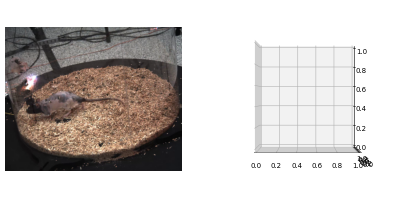

In [83]:
from celluloid import Camera
from load import read_data
from liftpose.plot import plot_pose_3d
import matplotlib.gridspec as gridspec
from load import plot_pose_2d
%matplotlib inline

session_id = 0

mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
fig = plt.figure(figsize=(20,10), dpi=50)

ax_2d = fig.add_subplot(121)
ax_3d = fig.add_subplot(122, projection='3d')
ax_3d.view_init(0, -90)
ax_2d.axis('off')

for idx, frame_id in enumerate(range(1000, 1500)):
    ax_2d = plot_pose_2d(frame_id%2000, cam_id=3, ax=ax_2d, mat=mat, cam_list=cam_list)
    plot_pose_3d(ax=ax_3d, tar=test_3d_gt[frame_id].copy(),
                 pred=test_3d_pred[frame_id].copy(),
                 bones=par_data["vis"]["bones"], 
                 limb_id=par_data["vis"]["limb_id"], 
                 colors=par_data["vis"]["colors"], 
                 normalize=False, show_pred_always=True)

    origin = test_3d_gt[frame_id][3]# if np.isnan(test_3d_gt[frame_id][3][0]) else [0,0,0]
    ax_3d.set_xbound(origin[0]-100, origin[0]+100)
    #ax_3d.set_ylim(-100,75)
    ax_3d.set_ylim(-25,150)
    ax_3d.set_zlim(origin[2]-100, origin[2]+100)
    
    plt.savefig(f'out_top/im{frame_id%2000}.jpg')
    ax_3d.clear()
    #cam.snap()
#cam.animate().save('test_marker.mp4')

In [155]:
!ffmpeg -loglevel panic -start_number 1000 -i out_top/im%d.jpg -vb 20M  -pix_fmt yuv420p out.mp4 -y
from IPython.display import Video
Video("out.mp4")

# Predict with missing limb

In [1]:
from liftpose.postprocess import load_test_results
from liftpose.vision_3d import camera_to_world
from liftpose.main import test as lp3d_test


#print(test_2d_new.shape, test_3d_new.shape)
# set some joints to zero
joints_to_miss_list = [['ArmL'], ['ElbowR'], ['KneeL'], ['KneeR']]

test_3d_pred = test_3d.copy()
for joints_to_miss in joints_to_miss_list:
    print(joints_to_miss)
    indices_to_miss = [names.index(j) for j in joints_to_miss]
    print(indices_to_miss)
    test_2d_new = test_2d.copy()
    test_3d_new = test_3d.copy()
    test_2d_new[:, indices_to_miss] = 0

    lp3d_test(par['out_dir'], test_2d=test_2d_new, test_3d=test_3d_new, test_kypts=test_keypoints)
    data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
    stat_2d, stat_3d = (
        torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
        torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
    )
    test_3d_gt, test_3d_pred_, good_keypts = load_test_results(data, stat_2d, stat_3d)
    test_3d_gt[np.logical_not(good_keypts)] = np.nan
    test_3d_pred[:, indices_to_miss] = test_3d_pred_[:, indices_to_miss]

NameError: name 'test_3d' is not defined

             err   joint
0       0.000011   HeadF
1       0.000020   HeadB
2       0.000062   HeadL
3       0.000017  SpineF
4       0.000050  SpineM
...          ...     ...
23591   0.000043    ArmR
23592  13.366201   KneeR
23593   6.259728   KneeL
23594   0.000028   ShinL
23595   0.000057   ShinR

[23360 rows x 2 columns]


Text(0, 0.5, 'Percentage of body length (%)')

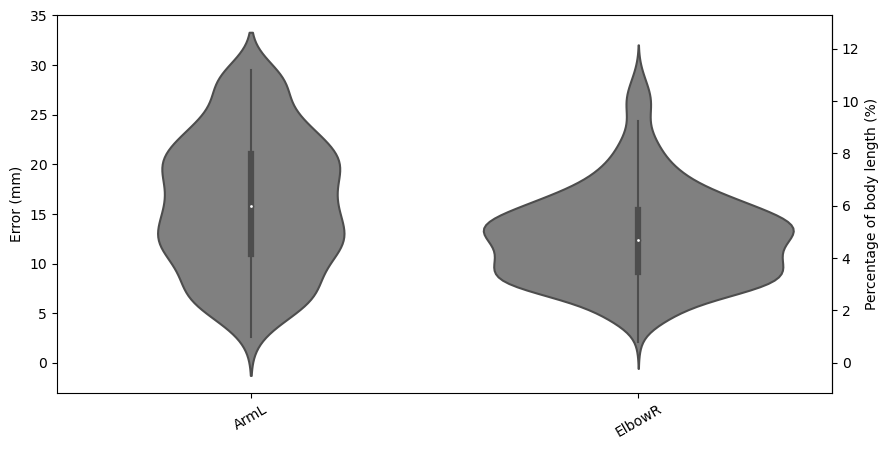

In [98]:
%matplotlib inline
from liftpose.plot import violin_plot
#order = ['HeadF', 'HeadB', 'HeadL', 'SpineM', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
order = sum(joints_to_miss_list, []) # flattens the list
order = ['ArmL', 'ElbowR']
plt.figure(figsize=(10,5), dpi=100)
names = par_data["vis"]["names"]
names = [n[0] for n in names]
ax = plt.gca()
violin_plot(ax, test_3d_gt, test_3d_pred, good_keypts, joints_name=names,units='mm', order=order)
#plt.ylim([0,25])

y = ax.secondary_yaxis('right', functions=(lambda x: x*100/263.67, lambda x: x*100/263.67))
y.set_ylabel(r'Percentage of body length (%)')

# video with missing limb

In [28]:
joints_to_miss = ['ArmL', 'ElbowL']

test_3d_pred = test_3d.copy()
print(joints_to_miss)
indices_to_miss = [names.index(j) for j in joints_to_miss]
print(indices_to_miss)
test_2d_new = test_2d.copy()
test_3d_new = test_3d.copy()
test_2d_new[:, indices_to_miss] = 0

lp3d_test(par['out_dir'], test_2d=test_2d_new, test_3d=test_3d_new, test_kypts=test_keypoints)
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
test_3d_gt[np.logical_not(good_keypts)] = np.nan
#test_3d_pred[:, indices_to_miss] = test_3d_pred_[:, indices_to_miss]
test_3d_pred[3, :] = 0

NameError: name 'test_3d' is not defined

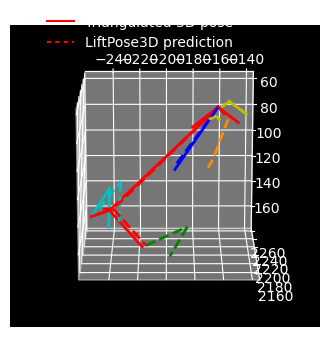

In [61]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=-75, azim=-90)

t = 50000
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"],
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            normalize=False, show_pred_always=True)

#for idx, pt in enumerate(test_3d_gt[t]):
#    ax.text(pt[0], pt[1], pt[2], str(idx))

#origin = test_3d_gt[t][3]
#print(origin)
#ax.set_xlim([origin[0]-100, origin[0]+100])
#ax.set_ylim([origin[1]-50, origin[1]+150])
#ax.set_zlim([-40,210])
#ax.set_xlim([-50, 100])

In [51]:
test_3d_gt[:, 3] = 0

array([[  44.602627,   98.039635, 2368.6338  ],
       [  55.135162,   87.44783 , 2357.3455  ],
       [  32.48483 ,   84.13299 , 2338.353   ],
       [        nan,         nan,         nan],
       [  92.73744 ,   74.21225 , 2266.4128  ],
       [ 139.86482 ,   79.83007 , 2201.0151  ],
       [  67.7572  ,   96.74013 , 2271.0632  ],
       [  85.60027 ,   89.03058 , 2235.8787  ],
       [ 128.32841 ,   97.8831  , 2181.8677  ],
       [ 164.8526  ,   96.37123 , 2218.8052  ],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [  56.47633 ,  104.98974 , 2290.4226  ],
       [  95.49967 ,  108.87375 , 2304.5122  ],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [ 154.53989 ,  107.45156 , 2239.444   ],
       [ 109.44316 ,  119.537125, 2202.5332  ],
       [ 126.607086,  139.94731 , 2186.6614  ],
       [ 166.58554 ,  125.86074 , 2227.0632  ]], dtype=float32)

In [36]:
test_3d_gt[0]

array([[  44.602627,   98.039635, 2368.6338  ],
       [  55.135162,   87.44783 , 2357.3455  ],
       [  32.48483 ,   84.13299 , 2338.353   ],
       [        nan,         nan,         nan],
       [  92.73744 ,   74.21225 , 2266.4128  ],
       [ 139.86482 ,   79.83007 , 2201.0151  ],
       [  67.7572  ,   96.74013 , 2271.0632  ],
       [  85.60027 ,   89.03058 , 2235.8787  ],
       [ 128.32841 ,   97.8831  , 2181.8677  ],
       [ 164.8526  ,   96.37123 , 2218.8052  ],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [  56.47633 ,  104.98974 , 2290.4226  ],
       [  95.49967 ,  108.87375 , 2304.5122  ],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [ 154.53989 ,  107.45156 , 2239.444   ],
       [ 109.44316 ,  119.537125, 2202.5332  ],
       [ 126.607086,  139.94731 , 2186.6614  ],
       [ 166.58554 ,  125.86074 , 2227.0632  ]], dtype=float32)

[pyplot.py:225]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


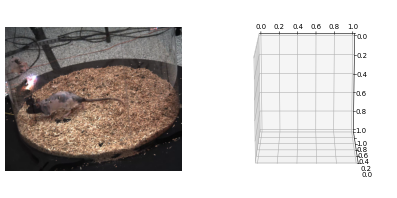

In [92]:
from celluloid import Camera
from load import read_data
from liftpose.plot import plot_pose_3d
import matplotlib.gridspec as gridspec
from load import plot_pose_2d
%matplotlib inline

session_id = 0

mat = [read_data(session_id, cid) for (cid,_) in enumerate(cam_list)]
fig = plt.figure(figsize=(10,5), dpi=50)

ax_2d = fig.add_subplot(121)
ax_3d = fig.add_subplot(122, projection='3d')
ax_3d.view_init(-75, -90)
ax_2d.axis('off')

for idx, frame_id in enumerate(range(1000, 1500)):
    ax_2d = plot_pose_2d(frame_id, cam_id=3, ax=ax_2d, mat=mat, cam_list=cam_list)
    plot_pose_3d(ax=ax_3d, tar=test_3d_gt[frame_id].copy(),
                 pred=test_3d_pred[frame_id].copy(),
                 bones=par_data["vis"]["bones"], 
                 limb_id=par_data["vis"]["limb_id"], 
                 colors=par_data["vis"]["colors"], 
                 normalize=False, show_pred_always=True)

    origin = test_3d_gt[frame_id][3]# if np.isnan(test_3d_gt[frame_id][3][0]) else [0,0,0]
    ax_3d.set_xbound(origin[0]-100, origin[0]+100)
    ax_3d.set_ylim(-100,75)
    ax_3d.set_zlim(origin[2]-100, origin[2]+100)
    
    plt.savefig(f'out_single_animal_missing_left/im{frame_id}.jpg')
    ax_3d.clear()
    #cam.snap()
#cam.animate().save('test_marker.mp4')

In [93]:
!ffmpeg -loglevel panic -start_number 1000 -i out_single_animal_missing_left/im%d.jpg  -pix_fmt yuv420p out.mp4 -y
from IPython.display import Video
Video("out.mp4")

# violin plot

In [53]:
from liftpose.postprocess import load_test_results
from liftpose.main import test as lp3d_test

lp3d_test(par['out_dir'])
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)
test_3d_gt[np.logical_not(good_keypts.reshape(-1, 20, 3))] = np.nan
test_3d_gt[:, 3] = test_3d_pred[:, 3]

[main.py:409]:INFO:starting testing in path: /home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln/
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:57]:INFO:total params: 4.31M
[lift.py:63]:INFO:loading ckpt from '/home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln/ckpt_best.pth.tar'
[lift.py:71]:INFO:ckpt loaded (epoch: 62 | err: 3.7535530310616707)
[lift.py:107]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/capture/out_across_undistort_bln/test_results.pth.tar


Text(0, 0.5, 'Percentage of body length (%)')

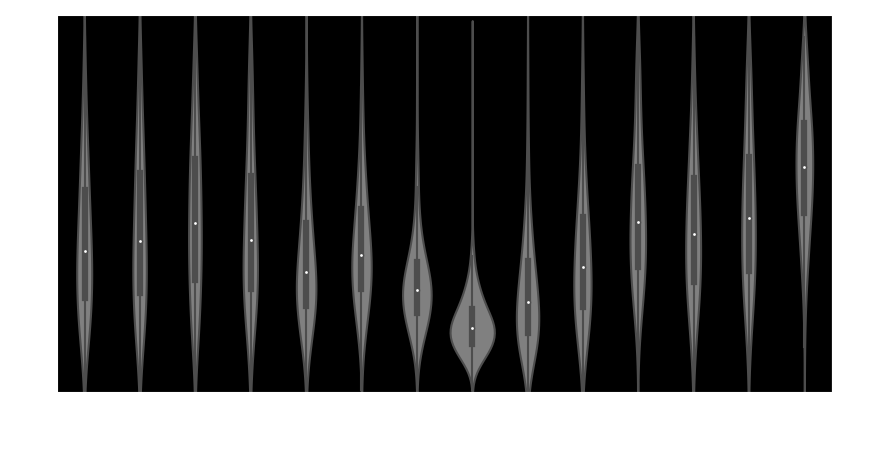

In [31]:
%matplotlib inline
from liftpose.plot import violin_plot
order = ['HeadF', 'SpineL', 'HipL', 'HipR', 'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']
plt.figure(figsize=(10,5), dpi=100)
names = par_data["vis"]["names"]
names = [n[0] for n in names]
ax = plt.gca()
violin_plot(ax, test_3d_gt, test_3d_pred, good_keypts, joints_name=names,units='mm', order=order)
plt.ylim([0,35])

y = ax.secondary_yaxis('right', functions=(lambda x: x*100/263.67, lambda x: x*100/263.67))
y.set_ylabel(r'Percentage of body length (%)')

(54000, 14)


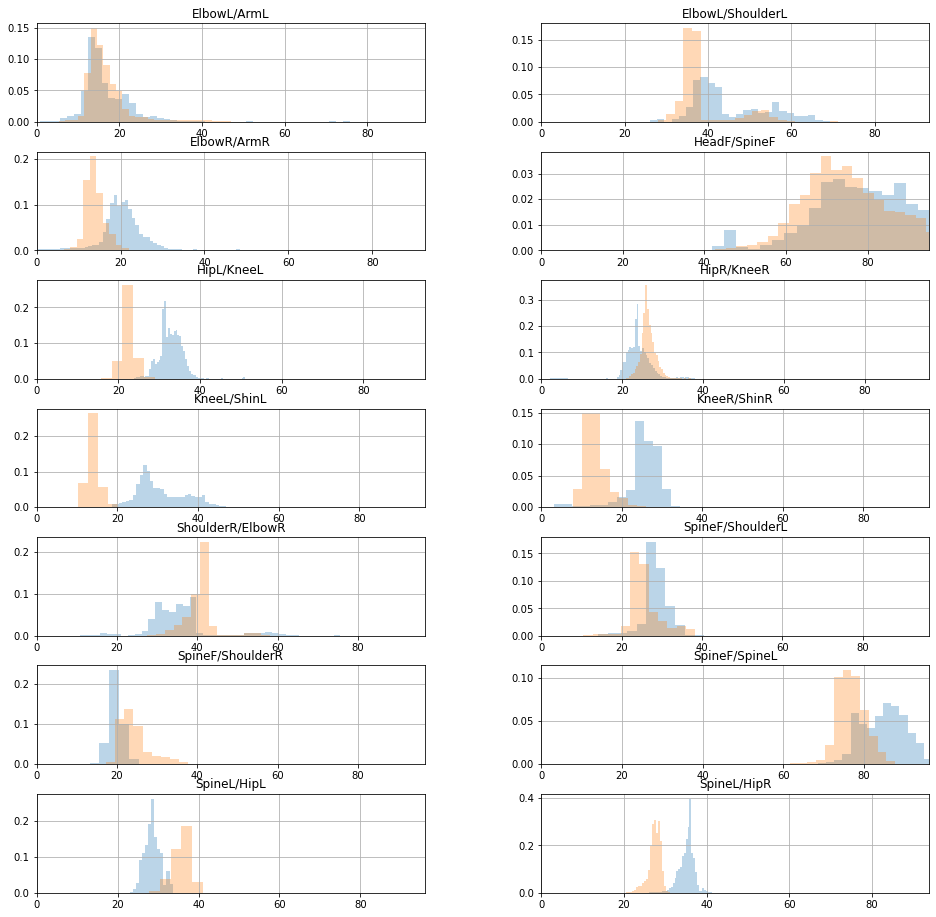

In [80]:
from liftpose.vision_3d import calculate_bone_length
import pandas as pd

bone_length = [calculate_bone_length(read_data(i, 3)['data_3d'].reshape(-1, 20, 3), par_data["vis"]["bones"]) for i in range(4)]
bones = par_data["vis"]["bones"]
n = par_data["vis"]["names"]
names = [n[b[0]][0] +  '/' + n[b[1]][0] for b in bones]
print(bone_length[0].shape)
p = pd.DataFrame(bone_length[0], columns=names)
p2 = pd.DataFrame(bone_length[1], columns=names)
p3 = pd.DataFrame(bone_length[2], columns=names)
p4 = pd.DataFrame(bone_length[3], columns=names)
p = pd.concat([p,p4], keys=['0', '1'], names=['Session_id', 'index'])

fig, ax = plt.subplots(7, 2, figsize=(16,16))
ax = p.groupby(by='Session_id').hist(ax=ax, alpha=0.3, bins=100, density=True)
for idx, (ax_, k) in enumerate(zip(ax[0], p.keys())):
    ax_.set_xlim([0,np.nanquantile(bone_length[0][idx], q=1)])

(array([6.5100e+02, 4.3950e+03, 2.4531e+04, 1.6286e+04, 4.7820e+03,
        1.7660e+03, 2.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00,
        5.7000e+01, 1.7000e+01, 1.4000e+01, 9.0000e+00, 2.0000e+01,
        2.4000e+01, 6.5000e+01, 2.8000e+01, 1.0200e+02, 3.9000e+01]),
 array([ 38.75555824,  53.096996  ,  67.43843376,  81.77987151,
         96.12130927, 110.46274703, 124.80418478, 139.14562254,
        153.4870603 , 167.82849805, 182.16993581, 196.51137357,
        210.85281132, 225.19424908, 239.53568684, 253.87712459,
        268.21856235, 282.56000011, 296.90143786, 311.24287562,
        325.58431338]),
 <a list of 20 Patch objects>)

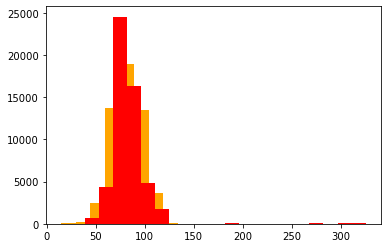

In [79]:
plt.hist(bone_length[0][:,0][np.logical_not(np.isnan(bone_length[0][:,0]))], color='orange', bins=20)
plt.hist(bone_length[1][:,0][np.logical_not(np.isnan(bone_length[1][:,0]))], color='red', bins=20)

plt.figure()
plt.hist(bone_length[0][:,0][np.logical_not(np.isnan(bone_length[0][:,0]))], color='orange', bins=20)
plt.hist(bone_length[1][:,0][np.logical_not(np.isnan(bone_length[1][:,0]))], color='red', bins=20)

In [77]:
bone_length[0].shape

(54000, 14)

In [65]:
np.nanquantile(bone_length[0][10], q=0.75)

36.75988220283428